# __DATA WRANGLING__

Este notebook se centra en el proceso de Data Wrangling con datos de Yelp y Google Maps. Realizamos una exploración inicial, limpieza y transformación de los datos para prepararlos para análisis posteriores. Este es un paso crucial en cualquier proyecto de ciencia de datos para asegurar la calidad y utilidad de los datos

## Configuraciones Globales e Importaciones

En esta sección,instalamos e importamos todas las librerías y/o módulos necesarios para nuestro proceso ETL y establecemos configuraciones globales de ser requerido.

In [1]:
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Importamos __LÍBRERIAS__ necesarias

In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
import os
import requests
import pandas as pd
import seaborn as sns
import pyspark.pandas as ps


from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from google.colab import userdata

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("EDA-Preliminar")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark


### Trabajamos con __GOOGLE MAPS__

DATASET: __METADATA-SITIOS__

In [5]:
metadata_df = spark.read.json("/content/drive/MyDrive/Colab-Notebooks/metadata-sitios/*.json")
metadata_df.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{[Wheelchair acce...|Porter Pharmacy, ...|       4.9|          [Pharmacy]|                NULL|0x88f16e41928ff68...|[[Friday, 8AM–6PM...|           32

In [6]:
fastfood = metadata_df.filter(F.col('name').like('%fast food%'))
fastfood.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|         longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{[Wheelchair acce...|Los mompis fast f...|       4.4|        [Restaurant]|                NULL|0x88d9a5968cde081...|[[Tuesday, 11:45A...|25.9409651999999

In [7]:
ubi_ny = metadata_df.filter(F.col('address').like('%new york%'))
ubi_ny.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                NULL|CUNY new york, Co...|       4.5|            [School]|                NULL|0x89c2f66ee150245...|                NULL|40.8203291999

In [8]:
from pyspark.sql.functions import array_contains

restaurantes_ny = metadata_df.filter(
    (array_contains(F.col('category'), 'Restaurant')) &  # Asegura que sea un restaurante
    (F.col('address').like('%New York%'))          # Asegura que el estado sea New York
)

restaurantes_ny.show()

+--------------------+---------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|              address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|         longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+---------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{NULL, NULL, [Goo...| Raffaello Kosher ...|       3.4|        [Restaurant]|This casual joint...|0x89c258ffaeaba94...|                NULL|        40.7

In [9]:
metadata_df.printSchema()

root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Getting here: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health and safety: array (nullable = true)


In [10]:
metadata_df.count()

3025011

In [11]:
metadata_psdf = metadata_df.pandas_api()
metadata_psdf.head()


,MISC,address,avg_rating,category,description,gmap_id,hours,latitude,longitude,name,num_of_reviews,price,relative_results,state,url
0,"([Wheelchair accessible entrance], None, None,...","Porter Pharmacy, 129 N Second St, Cochran, GA ...",4.9,[Pharmacy],None,0x88f16e41928ff687:0x883dad4fd048e8f8,"[[Friday, 8AM–6PM], [Saturday, 8AM–12PM], [Sun...",32.388300,-83.357100,Porter Pharmacy,16,None,"[0x88f16e41929435cf:0x5b2532a2885e9ef6, 0x88f1...",Open ⋅ Closes 6PM,https://www.google.com/maps/place//data=!4m2!3...
1,None,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",4.5,[Textile exporter],None,0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.215290,City Textile,6,None,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",Open now,https://www.google.com/maps/place//data=!4m2!3...
2,"([Wheelchair accessible entrance], None, [Good...","San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",4.4,[Korean restaurant],None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...",34.058092,-118.292130,San Soo Dang,18,None,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",Open ⋅ Closes 6PM,https://www.google.com/maps/place//data=!4m2!3...
3,"(None, None, None, None, None, None, None, Non...","Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",3.3,[Fabric store],None,0x80c2c89923b27a41:0x32041559418d447,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",34.023669,-118.232930,Nova Fabrics,6,None,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",Open ⋅ Closes 5PM,https://www.google.com/maps/place//data=!4m2!3...
4,"(None, None, None, None, None, None, None, Non...","Nobel Textile Co, 719 E 9th St, Los Angeles, C...",4.3,[Fabric store],None,0x80c2c632f933b073:0xc31785961fe826a6,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",34.036694,-118.249421,Nobel Textile Co,7,None,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",Open ⋅ Closes 5PM,https://www.google.com/maps/place//data=!4m2!3...


In [12]:
metadata_psdf.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 3025011 entries, 0 to 3025010
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   MISC              2334177 non-null  object 
 1   address           2944500 non-null  object 
 2   avg_rating        3025011 non-null  float64
 3   category          3007592 non-null  object 
 4   description       254289 non-null   object 
 5   gmap_id           3025011 non-null  object 
 6   hours             2237606 non-null  object 
 7   latitude          3025011 non-null  float64
 8   longitude         3025011 non-null  float64
 9   name              3024974 non-null  object 
 10  num_of_reviews    3025011 non-null  int64  
 11  price             275203 non-null   object 
 12  relative_results  2729953 non-null  object 
 13  state             2278556 non-null  object 
 14  url               3025011 non-null  object 
dtypes: float64(3), int64(1), object(11)

In [13]:
metadata_psdf.duplicated().sum()

26583

In [14]:
metadata_psdf.address[0]

'Porter Pharmacy, 129 N Second St, Cochran, GA 31014'

In [15]:
metadata_psdf.relative_results[0]

['0x88f16e41929435cf:0x5b2532a2885e9ef6',
 '0x88f16c32716531c1:0x5f19bdaa5044e4fa',
 '0x88f16e6e3f4a21df:0xcf495da9bb4d89ea']

In [16]:
metadata_psdf.state[0]

'Open ⋅ Closes 6PM'

In [17]:
metadata_psdf['state'].str.contains('Permanently closed').sum()

190813

In [18]:
metadata_psdf.url[0]

'https://www.google.com/maps/place//data=!4m2!3m1!1s0x88f16e41928ff687:0x883dad4fd048e8f8?authuser=-1&hl=en&gl=us'

In [19]:
metadata_psdf.category.explode().nunique()

4471

In [20]:
metadata_categories = metadata_psdf.category.explode().value_counts().to_frame(name='count')
metadata_categories['%'] = (metadata_categories['count']/len(metadata_psdf) * 100).round(2)
metadata_categories.head(10)

,count,%
Restaurant,97257,3.22
Auto repair shop,77854,2.57
Gas station,70143,2.32
Service establishment,66476,2.20
Beauty salon,65717,2.17
Convenience store,62165,2.06
Church,53069,1.75
Hair salon,51765,1.71
Nail salon,44597,1.47
ATM,42452,1.40


In [23]:
metadata_categories[metadata_categories.index.to_series().str.contains('Restaurant')]

,count,%
Restaurant,97257,3.22
Takeout Restaurant,23915,0.79
Delivery Restaurant,12323,0.41
Restaurant supply store,1070,0.04
Restaurant or cafe,120,0.00
Yakisoba Restaurant,2,0.00


In [24]:
fastfood_categories = 'Pizza restaurant|Pizzeria restaurant'
metadata_categories = metadata_categories[metadata_categories.index.to_series().str.contains(fastfood_categories)]
metadata_categories

,count,%
Pizza restaurant,23814,0.79


In [ ]:
metadata_psdf.MISC[0]

### DATASET: __REVIEWS-ESTADOS__

__REVIEWS-NEW_YORK__

Leer con pyspark

In [25]:
rw_newyork_df = spark.read.json("/content/drive/MyDrive/Colab-Notebooks/reviews-estados/reviews-New_York/*.json")
rw_newyork_df.show()

+--------------------+-----------------+----+------+----+--------------------+-------------+--------------------+
|             gmap_id|             name|pics|rating|resp|                text|         time|             user_id|
+--------------------+-----------------+----+------+----+--------------------+-------------+--------------------+
|0x89de09b4a848543...|      Sean Bailey|NULL|     3|NULL|Seems to be going...|1522976191648|11294936078038757...|
|0x89de09b4a848543...|  Rebekah Martino|NULL|     4|NULL|Great prices, pro...|1498137899161|10487654216930859...|
|0x89de09b4a848543...|Shirley Arrington|NULL|     4|NULL|Usually crowded w...|1497915516856|10310030037917646...|
|0x89de09b4a848543...|      Gees_Keeper|NULL|     1|NULL|pharmacy slow as ...|1497625448025|11320908474528403...|
|0x89de09b4a848543...|        Irene Ray|NULL|     5|NULL|             Love it|1514164540795|11173201801956000...|
|0x89de09b4a848543...|      Raúl Nieves|NULL|     5|NULL|         Best deals!|1519913588

In [26]:
rw_newyork_df.count()

2700000

In [27]:
rw_newyork_df.printSchema()

root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)



In [28]:
time = F.from_unixtime('1633197305')

In [29]:
rw_newyork_df = rw_newyork_df.withColumn('time', F.from_unixtime('time'))
rw_newyork_df.select("time").show()

+--------------------+
|                time|
+--------------------+
|+50231-03-13 06:0...|
|+49444-02-07 00:2...|
|+49437-01-20 03:3...|
|+49427-11-11 20:5...|
|+49951-12-19 13:1...|
|+50134-02-22 11:0...|
|+50024-10-16 02:3...|
|+49400-01-23 11:1...|
|+49391-11-01 13:5...|
|+50542-03-16 00:5...|
|+49379-01-21 08:2...|
|+49373-08-09 14:4...|
|+49902-11-10 12:3...|
|+49524-09-18 05:2...|
|+49350-11-26 23:0...|
|+48443-01-14 06:0...|
|+49318-03-24 18:4...|
|+49272-10-05 01:5...|
|+49299-05-17 03:3...|
|+49264-07-06 11:5...|
+--------------------+
only showing top 20 rows



In [30]:
rw_newyork_df_ = rw_newyork_df.withColumn('time', F.from_unixtime('time', 'yyyy-MM-dd HH:mm:ss'))
rw_newyork_df.select("time").show()

+--------------------+
|                time|
+--------------------+
|+50231-03-13 06:0...|
|+49444-02-07 00:2...|
|+49437-01-20 03:3...|
|+49427-11-11 20:5...|
|+49951-12-19 13:1...|
|+50134-02-22 11:0...|
|+50024-10-16 02:3...|
|+49400-01-23 11:1...|
|+49391-11-01 13:5...|
|+50542-03-16 00:5...|
|+49379-01-21 08:2...|
|+49373-08-09 14:4...|
|+49902-11-10 12:3...|
|+49524-09-18 05:2...|
|+49350-11-26 23:0...|
|+48443-01-14 06:0...|
|+49318-03-24 18:4...|
|+49272-10-05 01:5...|
|+49299-05-17 03:3...|
|+49264-07-06 11:5...|
+--------------------+
only showing top 20 rows



In [37]:
from pyspark.sql import functions as F

# Convierte la columna 'time' a formato de fecha y hora
rw_newyork_df = rw_newyork_df.withColumn('time', F.from_unixtime(F.unix_timestamp('time')))

# Muestra los resultados
rw_newyork_df.select("time").show()



+----+
|time|
+----+
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
+----+
only showing top 20 rows



In [31]:
rw_newyork_df = rw_newyork_df.withColumn("time", (F.col("time") / 1000))
rw_newyork_df.select("time").show()

+----+
|time|
+----+
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
+----+
only showing top 20 rows



In [32]:
# Transforma la columna "time" de milisegundos a timestamp.
rw_newyork_df = rw_newyork_df.withColumn("time", (F.col("time") / 1000).cast('timestamp'))
rw_newyork_df.select("time").show()

+----+
|time|
+----+
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
|NULL|
+----+
only showing top 20 rows



In [33]:
min_time = rw_newyork_df.agg(F.min("time")).collect()[0][0]
max_time = rw_newyork_df.agg(F.max("time")).collect()[0][0]

print("Min time: ", min_time)
print("Max time: ", max_time)

Min time:  None
Max time:  None


In [39]:
rw_newyork_df.filter(F.year(rw_newyork_df.time) < 2005).show()

+-------+----+----+------+----+----+----+-------+
|gmap_id|name|pics|rating|resp|text|time|user_id|
+-------+----+----+------+----+----+----+-------+
+-------+----+----+------+----+----+----+-------+



Leer con Pandas

In [40]:
data_path = "/content/drive/MyDrive/Colab-Notebooks/reviews-estados/reviews-New_York/1.json"
rw_NewYork_1 = pd.read_json(data_path, lines=True, dtype={'user_id': 'category'})

print(rw_NewYork_1.info())
rw_NewYork_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   user_id  150000 non-null  category
 1   name     150000 non-null  object  
 2   time     150000 non-null  int64   
 3   rating   150000 non-null  int64   
 4   text     87324 non-null   object  
 5   pics     4596 non-null    object  
 6   resp     16838 non-null   object  
 7   gmap_id  150000 non-null  object  
dtypes: category(1), int64(2), object(5)
memory usage: 13.5+ MB
None


,user_id,name,time,rating,text,pics,resp,gmap_id
0,113722104692308235141,Alvin Martinez,1603494795361,5,I'm late to posting this but this store especi...,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x89c25fc9494dce47:0x6d63c807b59a55
1,107293441492109320298,Johnnie Jackson,1620157037403,1,Very dissatisfied I did not get my phone the p...,None,"{'time': 1620268360920, 'text': 'We pride ours...",0x89c25fc9494dce47:0x6d63c807b59a55
2,100378585801819400296,Manie Blazer,1597431662039,5,Excellent very well done with professional car...,None,None,0x89c25fc9494dce47:0x6d63c807b59a55
3,114998161153019826512,Fashion Fiinds,1543773862044,5,Basing my review strictly on the service I rec...,None,"{'time': 1543855317372, 'text': 'Thanks for th...",0x89c25fc9494dce47:0x6d63c807b59a55
4,117178185728422297915,Andres Rieloff,1597279097718,1,Bad! Disorganized. I'm being totally honest. I...,None,None,0x89c25fc9494dce47:0x6d63c807b59a55


In [41]:
rw_NewYork_1.user_id.nunique()

111479

In [42]:
user_ratings = rw_NewYork_1.groupby('user_id')['rating'].count()
user_ratings_df = user_ratings.reset_index()
top_rated_users = user_ratings_df.sort_values(by='rating', ascending=False).head(10)
top_rated_users


,user_id,rating
51489,108963548051893895437,36
7238,101398793615263113244,33
68446,111654318848895716760,28
5372,101030940136685845419,23
16910,103237729589375373179,21
47703,108438741615903010377,21
24920,104731006993930939215,19
101594,116884758993374723673,18
51278,108940377826151998362,18
25395,104819208193648646391,17


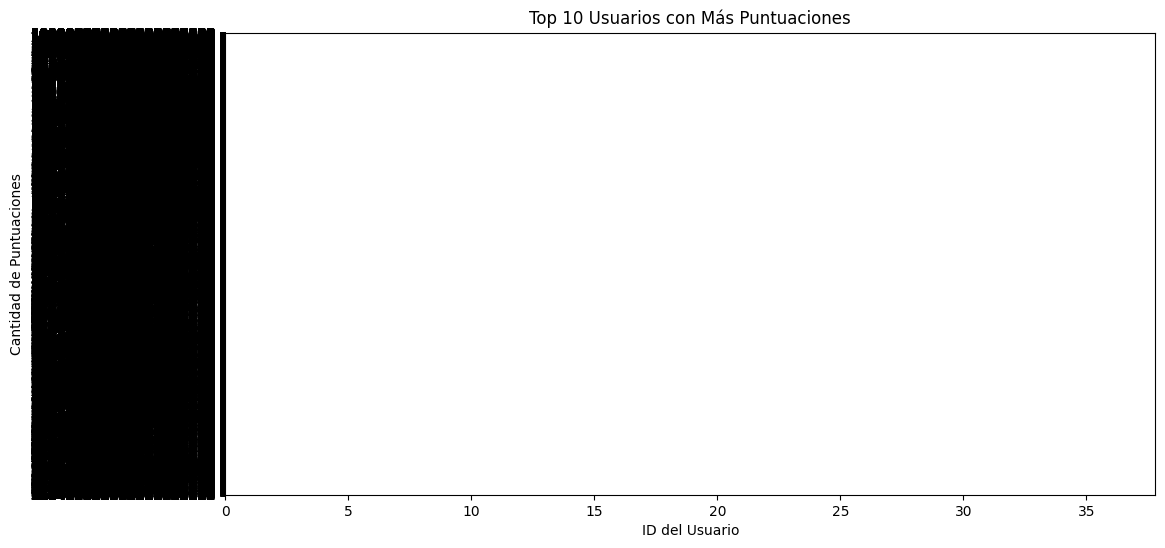

In [43]:
plt.figure(figsize=(12, 6))
sns.barplot(y='user_id', x='rating', data=top_rated_users, palette='viridis')

plt.title('Top 10 Usuarios con Más Puntuaciones')
plt.xlabel('ID del Usuario')
plt.ylabel('Cantidad de Puntuaciones')

plt.show()

In [44]:
rw_NewYork_1['time'] = pd.to_datetime(rw_NewYork_1['time'], unit='ms')
rw_NewYork_1['time'].head()

0   2020-10-23 23:13:15.361
1   2021-05-04 19:37:17.403
2   2020-08-14 19:01:02.039
3   2018-12-02 18:04:22.044
4   2020-08-13 00:38:17.718
Name: time, dtype: datetime64[ns]

In [ ]:
rw_NewYork_1['year'] = rw_NewYork_1['time'].dt.year
year_ratings = rw_NewYork_1.groupby('year')['rating'].count()
year_ratings_rw_NewYork_1 = year_ratings.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='rating', data=year_ratings_rw_NewYork_1, palette='viridis')

plt.title('Cantidad de Puntuaciones por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Puntuaciones')

plt.show()


In [45]:
rw_NewYork_1.describe(datetime_is_numeric=True)

,time,rating
count,150000,150000.000000
mean,2019-04-17 05:18:39.963829760,4.315000
min,1990-12-31 00:00:00,1.000000
25%,2018-05-04 12:39:44.100499968,4.000000
50%,2019-06-04 22:51:01.937500160,5.000000
75%,2020-07-29 17:08:41.240250112,5.000000
max,2021-09-08 02:08:59.373000,5.000000
std,NaN,1.186675


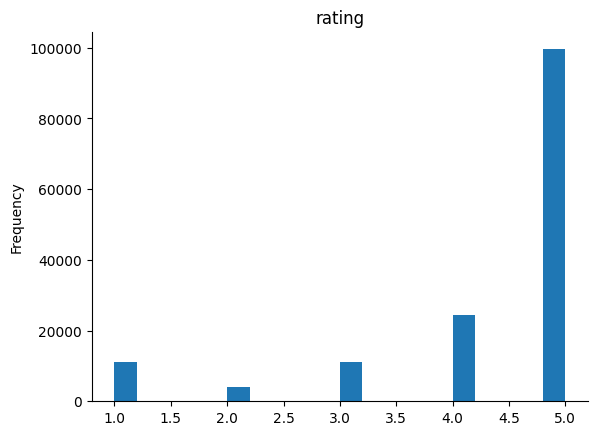

In [46]:
rw_NewYork_1['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

### REVIEWS - CALIFORNIA

In [ ]:
rw_nevada_sdf = spark.read.json("/content/drive/MyDrive/data/raw/google/reviews-estados/review-Nevada/*.json")
rw_nevada_sdf.show()

In [ ]:
rw_nevada_sdf.count()

In [ ]:
rw_nevada_sdf.printSchema()

In [ ]:

# Transforma la columna "time" de milisegundos a timestamp.
rw_nevada_sdf = rw_nevada_sdf.withColumn("time", (F.col("time") / 1000).cast('timestamp'))
rw_nevada_sdf.select("time").show()

In [ ]:
min_time = rw_nevada_sdf.agg(F.min("time")).collect()[0][0]
max_time = rw_nevada_sdf.agg(F.max("time")).collect()[0][0]

print("Min time: ", min_time)
print("Max time: ", max_time)

In [ ]:

rw_nevada_sdf.filter(F.year(rw_nevada_sdf.time) < 2005).show()

In [ ]:
rw_nevada_sdf.filter(F.year(rw_nevada_sdf.time) < 2005).count()

## YELP

DATASET: BUSINESS

In [ ]:
data_path = '/content/drive/MyDrive/data/raw/yelp/business.pkl'
yelp_business = pd.read_pickle(data_path)
print(yelp_business.info())
yelp_business.head()

In [ ]:
columns = yelp_business.columns.duplicated()
columns


In [ ]:
yelp_business = yelp_business.loc[:, ~columns]
yelp_business.head()


In [ ]:
yelp_business.state.unique()


In [ ]:
# Reemplazamos los NaN en 'state' por sus valores correspondientes de acuerdo a 'address', 'city' y 'postal_code'
yelp_business.at[0, 'state'] = 'CA'
yelp_business.at[1, 'state'] = 'MO'
yelp_business.at[2, 'state'] = 'AZ'


In [ ]:
yelp_business.head(3)

In [ ]:
yelp_business.isnull().sum()

In [ ]:
yelp_business.categories[0]

In [ ]:

yelp_business_categories = yelp_business.categories.str.split(',').explode().str.lstrip()
yelp_business_categories.nunique()

In [ ]:

yelp_business_categories = yelp_business_categories.value_counts().to_frame(name='count')
yelp_business_categories['%'] = round(yelp_business_categories['count']/len(yelp_business) * 100, 2)
yelp_business_categories.head(15)

In [ ]:
yelp_business_categories[yelp_business_categories.index.str.contains('V')]

In [ ]:
vegetarian_categories = 'Vegetarian|Vegan|Fruits & Veggies'
yelp_business_categories = yelp_business_categories[yelp_business_categories.index.str.contains(vegetarian_categories)]
yelp_business_categories


In [ ]:
vegetarian_categories = 'Vegetarian|Vegan|Fruits & Veggies'
yelp_business[yelp_business.categories.to_series().str.contains(vegetarian_categories)]


In [ ]:
# Normaliza 'attributes'
attributes = pd.json_normalize(yelp_business['attributes'])
attributes['business_id'] = yelp_business['business_id']
attributes = attributes.melt(id_vars='business_id', var_name='attribute_key', value_name='attribute_value')
attributes.dropna(inplace=True)
attributes.reset_index(drop=True, inplace=True)

In [ ]:
attributes[attributes['attribute_value'] == 'None']

In [ ]:
attributes = attributes[attributes['attribute_value'] != 'None']
attributes.reset_index(drop=True, inplace=True)


In [ ]:

attributes[attributes['attribute_value'] == 'None']

In [ ]:

attributes.info()

In [ ]:
# Normaliza 'categories'
categories = yelp_business[['business_id', 'categories']]
categories = categories.explode('categories')
categories = categories.rename(columns={'categories': 'category'})
categories['category'] = categories['category'].str.split(',')
categories = categories.explode('category')


In [ ]:
categories[categories.category.isnull()]